# Simulate MJP

In [6]:
import os
import sys
import torch
import numpy as np
import pandas as pd

import torch
from tqdm import tqdm
from typing import Tuple,List

from dataclasses import dataclass
from matplotlib import pyplot as plt
from torch.distributions import (
    Exponential,
    Categorical, 
    Dirichlet
)

# ANALYTICAL RATES

### Dirichlet Rate

In [70]:
@dataclass
class DirichletPriorOnRatesParam:
    concentration:float = 0.01
    num_states:int = 5

def generate_transition_rate_matrix(parameters:DirichletPriorOnRatesParam):
    """
    Generate a transition rate matrix for a Markov jump process.
    
    Parameters:
        num_states (int): Number of states in the Markov process.
        concentration (float or list): Concentration parameter(s) for the Dirichlet distribution. 
                                      Higher values lead to more uniform distributions.

    Returns:
        torch.Tensor: A transition rate matrix of shape (num_states, num_states).
    """
    num_states = parameters.num_states
    concentration = parameters.concentration

    # Initialize a tensor to store the transition rate matrix
    rate_matrix = torch.zeros(num_states, num_states)

    # Generate rows from Dirichlet distributions
    for i in range(num_states):
        # Create concentration parameters for the Dirichlet distribution
        # Each row should have num_states - 1 positive entries (excluding the diagonal)
        if isinstance(concentration, float):
            alpha = torch.full((num_states - 1,), concentration)
        else:
            alpha = torch.tensor(concentration[i])
        
        # Exclude diagonal element by creating a temporary row and then inserting
        temp_row = Dirichlet(alpha).sample()
        rate_matrix[i, :i] = temp_row[:i]
        rate_matrix[i, i+1:] = temp_row[i:]

        # Set the diagonal element such that the sum of the row is zero
        rate_matrix[i, i] = -torch.sum(rate_matrix[i])

    return rate_matrix

### Lotka Volterra

In [123]:
@dataclass
class LotkaVolterraParameters:
    alpha:float = 0.0005
    beta:float = 0.0001
    delta:float = 0.0001
    gamma:float = 0.0005

def lotka_volterra_rate(XY0,parameters:LotkaVolterraParameters):
    """
    parameters
    ----------
    X: torch.Tensor(number_of_paths,2) 

    returns
    -------
    new_states: torch.Tensor(number_of_paths,2,4)
    rates: torch.Tensor(number_of_paths,4) 
    """
    number_of_paths = XY0.size(0)
    #where_empty_population = torch.where(XY0 == 0)
    #XY0[where_empty_population] = 1e-6
    
    # new states available in next step
    new_states_mask = torch.Tensor([[1.,0],
                                    [-1.,0],
                                    [0.,1.],
                                    [0.,-1.]])

    mask_per_path = new_states_mask[None,:].repeat((number_of_paths,1,1))
    mask_per_path = mask_per_path.permute((0,2,1))

    #rates for new states available in next step
    X_up = parameters.alpha*XY0[:,0]
    X_down = parameters.beta*XY0[:,0]*XY0[:,1]

    Y_up = parameters.delta*XY0[:,0]*XY0[:,1]
    Y_down = parameters.gamma*XY0[:,1]

    rates = torch.cat([X_up[:,None],X_down[:,None],Y_up[:,None],Y_down[:,None]],dim=-1)
    #rates[][where_empty_population]= 0.001

    return mask_per_path,rates

### Repressilator

In [112]:
@dataclass
class RepressilatorParameters:
    # Parameter values
    kmu:float = 0.5
    kmo:float = 5e-4
    kp:float = 0.167
    gamma_m:float = 0.005776
    gamma_p:float = 0.001155
    kr:float = 1.0
    ku1:float = 224.0
    ku2:float = 9.0

def repressilator_mask():
    repressilator_update = np.array([
    # 0   1   2   3   4   5   6   7   8
    [ 1,  0,  0,  0,  0,  0,  0,  0,  0], # 0
    [ 0,  0,  1,  0,  0,  0,  0,  0,  0], # 1
    [ 0,  0,  0,  0,  1,  0,  0,  0,  0], # 2
    [ 0,  1,  0,  0,  0,  0,  0,  0,  0], # 3
    [ 0,  0,  0,  1,  0,  0,  0,  0,  0], # 4
    [ 0,  0,  0,  0,  0,  1,  0,  0,  0], # 5
    [-1,  0,  0,  0,  0,  0,  0,  0,  0], # 6
    [ 0,  0, -1,  0,  0,  0,  0,  0,  0], # 7
    [ 0,  0,  0,  0, -1,  0,  0,  0,  0], # 8
    [ 0, -1,  0,  0,  0,  0,  0,  0,  0], # 9
    [ 0,  0,  0, -1,  0,  0,  0,  0,  0], # 10
    [ 0,  0,  0,  0,  0, -1,  0,  0,  0], # 11
    [ 0,  0,  0,  0,  0,  0, -1,  0,  0], # 12
    [ 0,  0,  0,  0,  0,  0,  0, -1,  0], # 13
    [ 0,  0,  0,  0,  0,  0,  0,  0, -1], # 14
    [ 0,  0,  0,  0,  0, -1,  0,  0,  1], # 15
    [ 0, -1,  0,  0,  0,  0,  1,  0,  0], # 16
    [ 0,  0,  0, -1,  0,  0,  0,  1,  0], # 17
    [ 0,  0,  0,  0,  0,  1,  0,  0, -1], # 18
    [ 0,  1,  0,  0,  0,  0, -1,  0,  0], # 19
    [ 0,  0,  0,  1,  0,  0,  0, -1,  0], # 20
    ], dtype=float)
    return torch.Tensor(repressilator_update)

def repressilator_rate(population,params:RepressilatorParameters):
    number_of_paths = population.size(0)
    new_states_mask = repressilator_mask()
    mask_per_path = new_states_mask[None,:].repeat((number_of_paths,1,1))
    mask_per_path = mask_per_path.permute((0,2,1))

    # Extract each component from the population tensor
    m1, p1, m2, p2, m3, p3, n1, n2, n3 = population[:, 0], population[:, 1], population[:, 2], population[:, 3], population[:, 4], population[:, 5], population[:, 6], population[:, 7], population[:, 8]
    
    # Initialize propensities tensor
    propensities = torch.zeros(population.shape[0], 21)
    
    # Update propensities based on model logic
    propensities[:, 0] = torch.where(n3 == 0, params.kmu, params.kmo)
    propensities[:, 1] = torch.where(n1 == 0, params.kmu, params.kmo)
    propensities[:, 2] = torch.where(n2 == 0, params.kmu, params.kmo)
    propensities[:, 3] = params.kp * m1
    propensities[:, 4] = params.kp * m2
    propensities[:, 5] = params.kp * m3
    propensities[:, 6] = params.gamma_m * m1
    propensities[:, 7] = params.gamma_m * m2
    propensities[:, 8] = params.gamma_m * m3
    propensities[:, 9] = params.gamma_p * p1
    propensities[:, 10] = params.gamma_p * p2
    propensities[:, 11] = params.gamma_p * p3
    propensities[:, 12] = params.gamma_p * n1
    propensities[:, 13] = params.gamma_p * n2
    propensities[:, 14] = params.gamma_p * n3
    propensities[:, 15] = params.kr * p3 * (n3 < 2)
    propensities[:, 16] = params.kr * p1 * (n1 < 2)
    propensities[:, 17] = params.kr * p2 * (n2 < 2)
    propensities[:, 18] = params.ku1 * (n3 == 1) + 2 * params.ku2 * (n3 == 2)
    propensities[:, 19] = params.ku1 * (n1 == 1) + 2 * params.ku2 * (n1 == 2)
    propensities[:, 20] = params.ku1 * (n2 == 1) + 2 * params.ku2 * (n2 == 2)
    
    return mask_per_path,propensities

# SOLVERS

## Utils


In [55]:
def states_at_grid(paths_batch, times, time_grid):
    """
    For a simulation of states and times, for each value of the time grid,
    assigns the state with the rightmost time to the grid time.

    :param times: torch.Tensor(batch_size,number_of_timesteps)
    :param paths_batch torch.Tensor(batch_size,number_of_timesteps,number_of_spins):
    :param time_grid: torch.Tensor(number_of_timesteps)
    :return:
    """
    if len(times.shape) == 3:
        times = times.squeeze()

    assert torch.all(times[:, 0] == 0.)
    assert time_grid[0] == 0.
    assert paths_batch.shape[:-1] == times.shape

    batch_size = paths_batch.shape[0]
    tau = time_grid[1]
    time_grid_ = time_grid + tau # arrival is to the left of the box

    x = time_grid_[None, None, :] - times[:, :, None]
    times_not_allowed = times[:, :, None] > time_grid_[None, None, :]
    x[times_not_allowed] = torch.inf
    min_indices = torch.argmin(x, axis=1)

    arrivals = times[torch.arange(batch_size)[:, None], min_indices]
    states_at_arrival = paths_batch[torch.arange(batch_size)[:, None], min_indices, :]

    return states_at_arrival,arrivals

In [114]:
def choose_new_states(new_states_available,which_state_to_take):
    """
    selects from available according to which_state_to_take 

    parameters
    ----------

    new_states_available: (number_of_paths,dimension,number_of_new_possible)
    which_state_to_take :(number_of_paths) \in [0,number_of_new_possible]

    returns
    -------
    new_states: (number_of_paths,dimension)
    """
    # Assuming N, D, and number_of_states are defined
    N = new_states_available.size(0)  # example value
    D = new_states_available.size(1)   # example value
    # To use selected_index to index X, we need to unsqueeze it to make it broadcastable
    which_state_to_take = which_state_to_take.unsqueeze(-1).expand(N, D)  # Shape (N, D)
    # Now, gather the elements. We want to gather along the last dimension
    new_states = torch.gather(new_states_available, 2, which_state_to_take.unsqueeze(2)).squeeze(2)  # Use unsqueeze to match the gather requirement and squeeze to drop the extra dimension
    
    return new_states

In [85]:
def count_values_along_time(paths, num_states):
    """
    Count each integer's occurrences at each timestep along the second dimension of a tensor.

    Parameters:
        paths (torch.Tensor): A 2D tensor of shape (N, T) containing integer values.
        num_states (int): The number of distinct states (integer values).

    Returns:
        torch.Tensor: A 2D tensor of shape (T, num_states) where each row gives the counts
                      of each state at that timestep.
    """
    N, T = paths.shape
    counts = torch.zeros((T, num_states), dtype=torch.long)

    # Process each timestep
    for t in range(T):
        # Extract the data at timestep t
        timestep_data = paths[:, t]
        # Count occurrences of each state at this timestep
        for state in range(num_states):
            counts[t, state] = torch.sum(timestep_data == state)

    return counts

## Gillespie


In [124]:
def gillespie_mask(X0,rate_function,number_of_times=100)->Tuple[torch.Tensor,torch.Tensor]:
    """
    This gillespie simulation scheme works for unbounded states space of the type encountered
    in birth-death processes, it expects a rate_function which  outputs a mask per possible transition,
    i.e. once a trnasition is desided the mask corresponding to this transition is obtained and applied 
    to the state.

    # http://be150.caltech.edu/2019/handouts/12_stochastic_simulation_all_code.html

    parameters
    ----------

    X0: initial conditions
    rate_function: function -> new_states_available,rates

    returns
    -------
    paths,times
    """    
    batch_size = X0.shape[0]

    # Initialize process
    times = torch.full((batch_size, 1), 0.)
    paths = X0.unsqueeze(1)

    for time_index in range(number_of_times):
        X = paths[:,-1,:]
        current_time = times[:,-1]
        mask_per_path,rates = rate_function(X, current_time)

        # Time to next reactions
        rates_sum = torch.sum(rates, axis=1)

        # corrects rate in case 0 probabilities occur
        where_no_events = torch.where(rates_sum == 0.)
        rates[where_no_events] = 1.
        rates_sum = torch.sum(rates, axis=1)
        transition_probabilities = rates/rates_sum[:,None]

        time_between_events = Exponential(rates_sum).sample()
        new_times = current_time + time_between_events

        # selects next state
        which_state_to_take = Categorical(transition_probabilities).sample()
        mask_to_apply = choose_new_states(mask_per_path,which_state_to_take)
        new_states = X.clone() + mask_to_apply

        #makes sure that at no probabilities stays the same
        new_states[where_no_events] = X[where_no_events]

        #update paths and times
        paths = torch.concatenate([paths,
                                 new_states.unsqueeze(1)], dim=1)

        times = torch.concatenate([times,
                                   new_times.unsqueeze(1)],dim=1)
    
    return paths,times

In [49]:
def gillespie(X0,Q,number_of_times=100)->Tuple[torch.Tensor,torch.Tensor]:
    """
    # http://be150.caltech.edu/2019/handouts/12_stochastic_simulation_all_code.html

    parameters
    ----------

    X0: initial conditions
    q_rate_function: function -> new_states_available,rates

    returns
    -------
    paths,times
    """
    num_states = Q.size(0)
    batch_size = X0.shape[0]

    rates_from_Q  = lambda X,Q : Q[X]
    Q_r = Q.clone()
    Q_r[range(num_states),range(num_states)] = 0

    # Initialize process
    times = torch.full((batch_size, 1), 0.)
    paths = X0.unsqueeze(1)

    for time_index in range(number_of_times):
        X = paths[:,-1]
        current_time = times[:,-1]

        # rates and probabilities
        rates = rates_from_Q(X, Q_r)
        rates_sum = -Q[X,X].squeeze() #diagonal sum to 0
        transition_probabilities = rates/rates_sum[:,None]

        #times
        time_between_events = Exponential(rates_sum).sample()
        new_times = current_time + time_between_events

        # selects next state
        new_states = Categorical(transition_probabilities).sample()

        #update paths and times
        paths = torch.concatenate([paths,
                                   new_states.unsqueeze(1)], dim=1)

        times = torch.concatenate([times,
                                   new_times.unsqueeze(1)],dim=1)
    
    return paths,times

In [156]:
d_param = DirichletPriorOnRatesParam()
Q0 = generate_transition_rate_matrix(d_param)
Q1 = generate_transition_rate_matrix(d_param)

X0 = torch.randint(0,d_param.num_states,(300,))
paths0,times0 = gillespie(X0,Q0,number_of_times=1000)
paths1,times1 = gillespie(X0,Q1,number_of_times=1000)

# set everything in a grid
time_grid = torch.arange(0,101,1,dtype=float)
paths0_grid,arrivals0 = states_at_grid(paths1.unsqueeze(-1), times0, time_grid)
paths1_grid,arrivals1 = states_at_grid(paths0.unsqueeze(-1), times0, time_grid)

paths0_grid = paths0_grid.squeeze()
paths1_grid = paths1_grid.squeeze()

histograms_on_time_0 = count_values_along_time(paths0_grid, d_param.num_states)
histograms_on_time_1 = count_values_along_time(paths1_grid, d_param.num_states)

histograms_on_time_0 = histograms_on_time_0/paths0_grid.shape[0]
histograms_on_time_1 = histograms_on_time_1/paths1_grid.shape[0]

In [157]:
print(histograms_on_time_0[-1])
print(histograms_on_time_1[-1])

tensor([0.4867, 0.0000, 0.0000, 0.0000, 0.5133])
tensor([0.0000, 0.0000, 0.5167, 0.0033, 0.4800])


In [158]:
print(histograms_on_time_0[0])
print(histograms_on_time_1[0])

tensor([0.4233, 0.0567, 0.1633, 0.0633, 0.2933])
tensor([0.0867, 0.0567, 0.4100, 0.1433, 0.3033])


# OPTIMAL TRANSPORT

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import ot  # Import Python Optimal Transport library

In [132]:
def solve_regularized_transport(histogram_a,histogram_b):
    # Setting up the distributions
    # Uniform distribution of 10 points from 0 to 1
    n_points = histogram_a.shape[0]

    # Generate positions for each point in the distributions
    x = np.linspace(0, 1, n_points).reshape(-1, 1)  # Positions for a
    y = np.linspace(0, 1, n_points).reshape(-1, 1)  # Positions for b

    # Cost matrix: Euclidean distance
    C = ot.dist(x, y)
    C = C / C.max()  # Normalize cost for stability

    # Regularization parameter
    lambda_reg = 0.1  # Small lambda means more regularization

    # Solve the regularized optimal transport problem using Sinkhorn algorithm
    P = ot.sinkhorn(histogram_a, histogram_b, C, lambda_reg,numItermax=1000)

    # Compute the actual transport distance
    transport_distance = np.sum(P * C)  # Dot product of P and C
    
    return C,P,transport_distance

In [136]:
def get_trasport_over_time(histograms_on_time_0,histograms_on_time_1):
    number_of_time_steps = histograms_on_time_0.shape[0]
    transport_cost_over_time = torch.zeros(number_of_time_steps)

    for time_index in range(number_of_time_steps):
        histogram_a = histograms_on_time_0[time_index].numpy()
        histogram_b = histograms_on_time_1[time_index].numpy()
        C,P,transport_distance = solve_regularized_transport(histogram_a,histogram_b)
        transport_cost_over_time[time_index] = transport_distance

    return transport_cost_over_time

In [144]:
d_param = DirichletPriorOnRatesParam(concentration=0.01)
Q0 = generate_transition_rate_matrix(d_param)
Q1 = generate_transition_rate_matrix(d_param)
X0 = torch.randint(1,d_param.num_states,(300,))
TAU = np.linspace(0.,1.,10)

time_grid = torch.arange(0,101,1,dtype=float)
paths0,times0 = gillespie(X0,Q0,number_of_times=100)
paths0_grid,arrivals0 = states_at_grid(paths1.unsqueeze(-1), times0, time_grid)
paths0_grid = paths0_grid.squeeze()
histograms_on_time_0 = count_values_along_time(paths0_grid, d_param.num_states)
number_of_time_steps = histograms_on_time_0.shape[0]

for tau in TAU:
    print(f"Tau: {tau}")
    Q_tau = interpolation_tau*Q0 + (1.-interpolation_tau)*Q1
    paths1,times1 = gillespie(X0,Q_tau,number_of_times=100)

    # set everything in a grid
    paths1_grid,arrivals1 = states_at_grid(paths1.unsqueeze(-1), times0, time_grid)
    paths1_grid = paths1_grid.squeeze()

    histograms_on_time_1 = count_values_along_time(paths1_grid, d_param.num_states)
    histograms_on_time_1 = histograms_on_time_1/paths1_grid.shape[0]

    transport_over_time = get_trasport_over_time(histograms_on_time_0,histograms_on_time_1)
    print(transport_over_time.mean())

Tau: 0.0


c:\Users\cesar\anaconda4\envs\rate_matching\lib\site-packages\ot\bregman\_sinkhorn.py:499: RuntimeWarning: overflow encountered in divide
  u = 1. / nx.dot(Kp, v)
c:\Users\cesar\anaconda4\envs\rate_matching\lib\site-packages\ot\bregman\_sinkhorn.py:506: UserWarning: Warning: numerical errors at iteration 124
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


tensor(13.7929)
Tau: 0.1111111111111111
tensor(13.8747)
Tau: 0.2222222222222222
tensor(13.6804)
Tau: 0.3333333333333333
tensor(13.9385)
Tau: 0.4444444444444444
tensor(13.9176)
Tau: 0.5555555555555556
tensor(13.7662)
Tau: 0.6666666666666666
tensor(13.8569)
Tau: 0.7777777777777777
tensor(13.6817)
Tau: 0.8888888888888888
tensor(14.0167)
Tau: 1.0
tensor(13.8706)


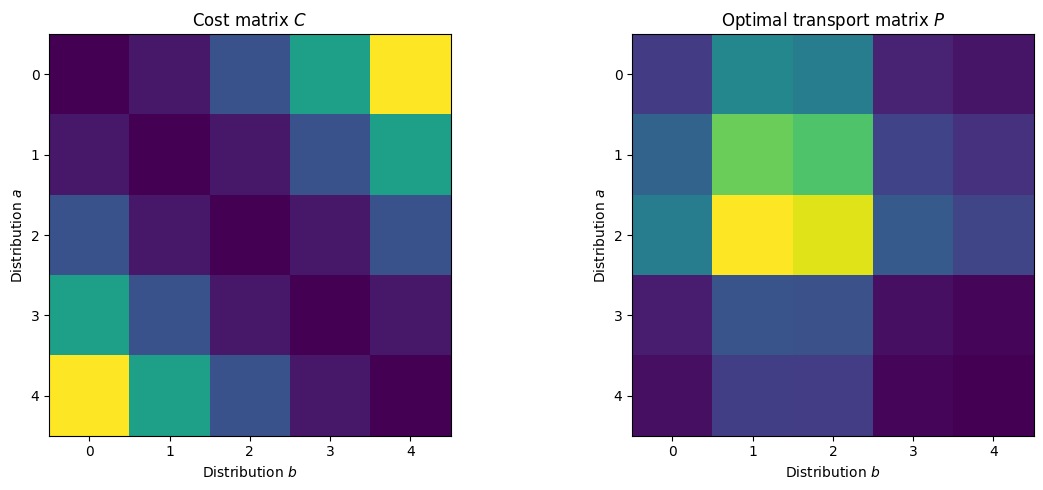

In [125]:
# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot cost matrix
ax[0].imshow(C, interpolation='nearest')
ax[0].set_title('Cost matrix $C$')
ax[0].set_xlabel('Distribution $b$')
ax[0].set_ylabel('Distribution $a$')

# Plot optimal transport matrix
ax[1].imshow(P, interpolation='nearest')
ax[1].set_title('Optimal transport matrix $P$')
ax[1].set_xlabel('Distribution $b$')
ax[1].set_ylabel('Distribution $a$')

plt.tight_layout()
plt.show()